CNN Image Classifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import seaborn as sns
import pandas as pd
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

### Dataset Loading

In [ ]:
ds_path = "/content/drive/MyDrive/Ai flower dataset/Flower Classification/Flower Classification/Train"

In [ ]:
# Initialize a variable to store the total number of images
total_images = 0
for root, dirs, files in os.walk(ds_path):
  # Count the number of files in each directory
  num_files = len(files)
  total_images += num_files
print("Total number of images:", total_images)

# Count images per class
classes = os.listdir(ds_path)
images_per_class = {}
for class_name in classes:
  class_path = os.path.join(ds_path, class_name)
  if os.path.isdir(class_path):
    images_per_class[class_name] = len(os.listdir(class_path))
print("Total number of images per classes:", images_per_class)



Total number of images: 3850
Total number of images per classes: {'rose': 776, 'tulip': 549, 'sunflower': 725, 'daisy': 756, 'dandelion': 1044}


In [ ]:
import os
class_names = sorted(os.listdir(ds_path))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 5 classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [ ]:
from PIL import Image, UnidentifiedImageError
import os

corrupted_images = []

for class_name in class_names:
    class_path = os.path.join(ds_path, class_name)
    print(f"Checking in: {class_path}")

    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)
                print(f"Corrupted image detected: {img_path}")
                try:
                    os.remove(img_path)
                    print(f"Deleted: {img_path}")
                except Exception as e:
                    print(f"Failed to delete {img_path}: {e}")

# Summary
if corrupted_images:
    print(f"\nTotal corrupted images deleted: {len(corrupted_images)}")
else:
    print("\nNo corrupted images found.")


Checking in: /content/drive/MyDrive/Ai flower dataset/Flower Classification/Flower Classification/Train/daisy
Checking in: /content/drive/MyDrive/Ai flower dataset/Flower Classification/Flower Classification/Train/dandelion
Checking in: /content/drive/MyDrive/Ai flower dataset/Flower Classification/Flower Classification/Train/rose
Checking in: /content/drive/MyDrive/Ai flower dataset/Flower Classification/Flower Classification/Train/sunflower
Checking in: /content/drive/MyDrive/Ai flower dataset/Flower Classification/Flower Classification/Train/tulip

No corrupted images found.


In [ ]:

# Define the path to the directory containing the images
train_ds = tf.keras.utils.image_dataset_from_directory(
ds_path,
batch_size=32,
image_size=(256, 256),
shuffle=True,
seed=123,
validation_split=0.2,
subset="training",
)


Found 3850 files belonging to 5 classes.
Using 3080 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
ds_path,
batch_size=32,
image_size=(256, 256),
shuffle=True,
seed=123,
validation_split=0.2,
subset="validation",
)


Found 3850 files belonging to 5 classes.
Using 770 files for validation.


In [ ]:
# Augmentation and normalization
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])




In [ ]:
import os
class_names = sorted(os.listdir(ds_path))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 5 classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


Text(0.5, 1.0, 'daisy')

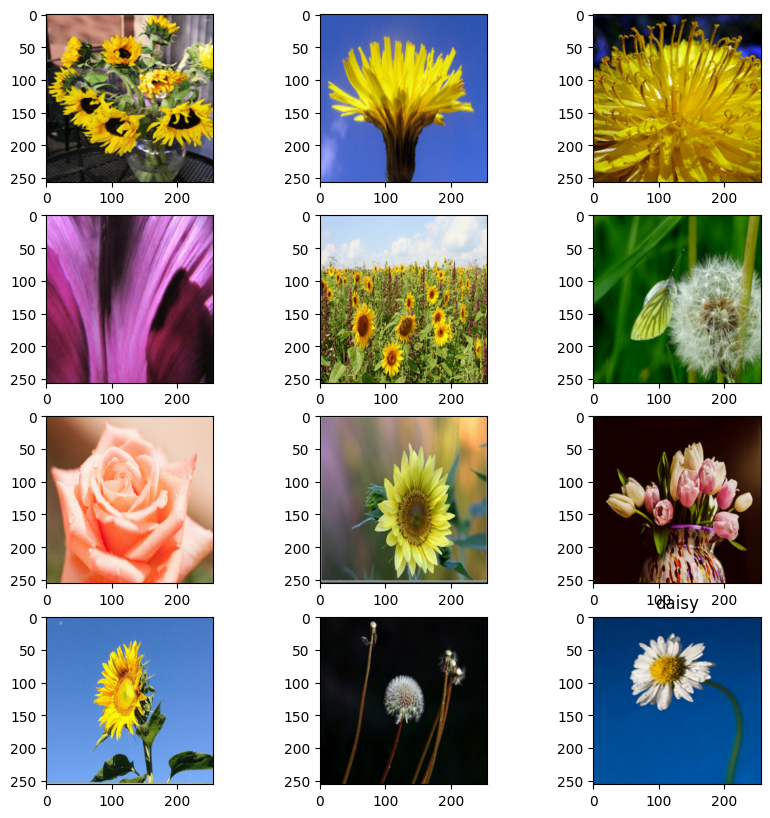

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
plt.title(class_names[labels[i]])

<ipython-input-12-8e5a6810bb72>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data["Class"], y=data["Number of Images"], palette="Set2")


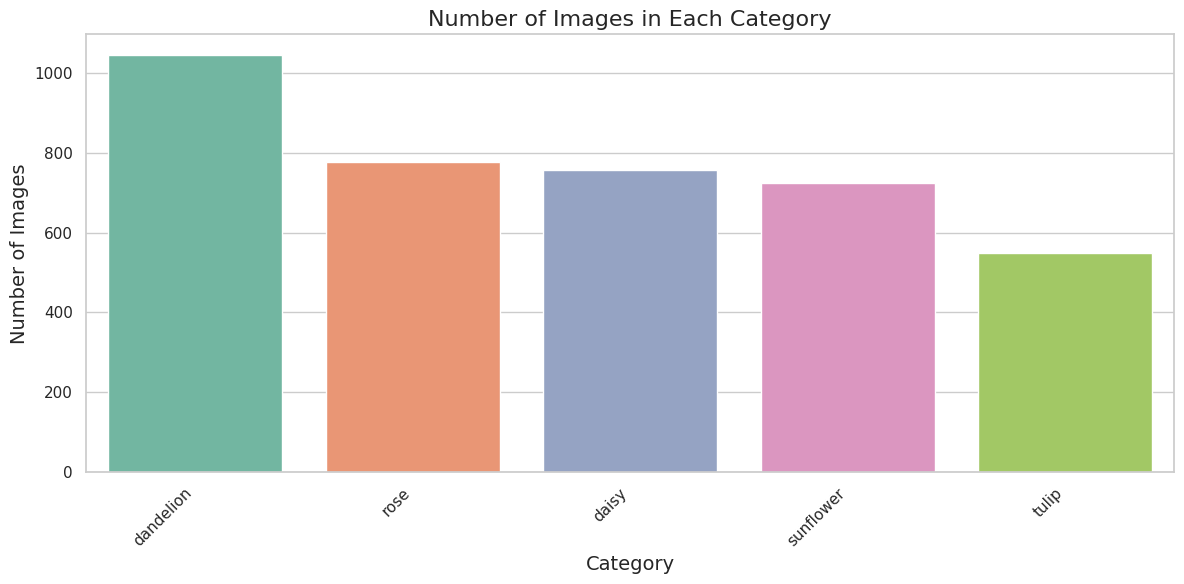

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

def plot_image_category_distribution(directory):
    categories = []

    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            num_images = len([image_name for image_name in os.listdir(class_dir) if image_name.lower().endswith('.jpg')])
            categories.append((class_name, num_images))

    categories.sort(key=lambda x: x[1], reverse=True)

    class_names, image_counts = zip(*categories)

    data = {"Class": class_names, "Number of Images": image_counts}

    sns.set(style="whitegrid", palette="muted")

    plt.figure(figsize=(12, 6))
    sns.barplot(x=data["Class"], y=data["Number of Images"], palette="Set2")

    plt.xticks(rotation=45, ha="right")

    plt.title("Number of Images in Each Category", fontsize=16)
    plt.xlabel("Category", fontsize=14)
    plt.ylabel("Number of Images", fontsize=14)

    plt.tight_layout()
    plt.show()

plot_image_category_distribution(ds_path)


## Building Baseline(Simple) CNN model

In [ ]:
def generate_model(image_height, image_width, nchannels, num_classes):
  """
  This function will generate a model with set of hyperparameters defined above.
  Input Args:
  image_height[int] = Height of an image.
  image_width[int] = Width of an image.
  nchannels[int] = Number of channels in image.
  num_classes[int] = Number of classes in dataset.
  Output Args:
  model-> A CNN model.
  """
  baseline_model = tf.keras.Sequential([
      # Rescaling and input layer, [For keras the input shape must be(image height, image width, channels)]
      layers.Rescaling(1./255, input_shape=(image_height,image_width, nchannels)),
      # First Block of Convolution and Pooling Operations.
      layers.Conv2D(32, (3,3), padding="same", activation="relu"),
      layers.MaxPooling2D(2,2),
      # Second Block of Convolution and Pooling Operations.
      layers.Conv2D(64, (3,3), padding="same", activation="relu"),
      layers.MaxPooling2D(2,2),
      # Third Block of Convolution and Pooling Operations.
      layers.Conv2D(128, (3,3), padding="same", activation="relu"),
      layers.MaxPooling2D(2,2),

      # Fully connected classifier.
      layers.Flatten(),
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
  ])
  return baseline_model

In [ ]:
batch_size = 32
img_height = 256
img_width = 256
dropout_rate = 0.2

In [ ]:
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=5)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=5)))

In [ ]:
num_classes = len(class_names)
base_model = generate_model(img_height, img_width, 3, num_classes)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
base_model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
base_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,881,093 (64.40 MB)

 Trainable params: 16,881,093 (64.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras"),
keras.callbacks.EarlyStopping(monitor="val_loss", patience=5 ),
]

In [ ]:
epochs = 50
history = base_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callbacks]
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 210ms/step - accuracy: 0.3340 - loss: 1.5280 - val_accuracy: 0.4870 - val_loss: 1.1883
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.5307 - loss: 1.1203 - val_accuracy: 0.5922 - val_loss: 1.0385
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy: 0.6381 - loss: 0.9090 - val_accuracy: 0.6052 - val_loss: 1.0476
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 163ms/step - accuracy: 0.7396 - loss: 0.7033 - val_accuracy: 0.5247 - val_loss: 1.3775
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.8048 - loss: 0.5425 - val_accuracy: 0.5558 - val_loss: 1.6475
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.8841 - loss: 0.3175 - val_accuracy: 0.5675 - val_loss: 1.8401
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.9357 - loss: 0.1934 - val_accuracy: 0.6091 - val_loss: 2.0209


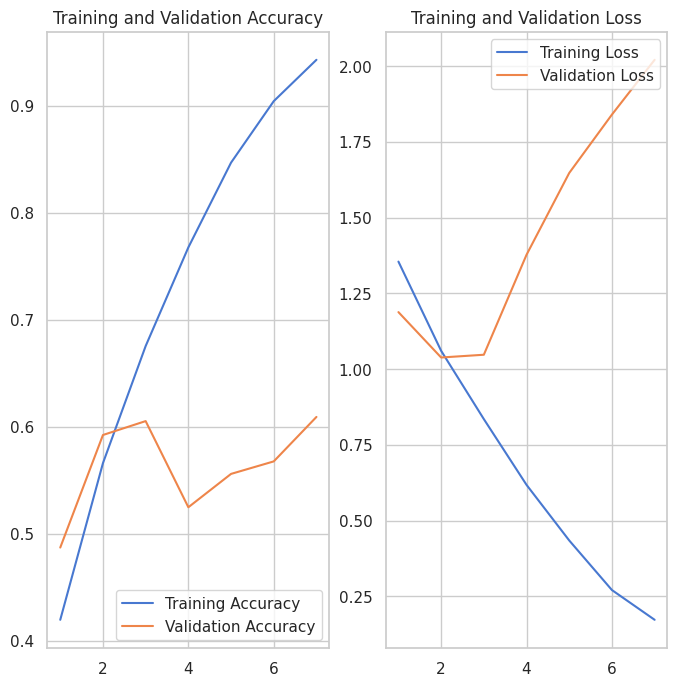

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Adjust the lengths of the arrays to match the actual number of epochs executed
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_accuracy = base_model.evaluate(val_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.6262 - loss: 1.9164
Test Loss: 2.020874261856079
Test Accuracy: 0.6090909242630005


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


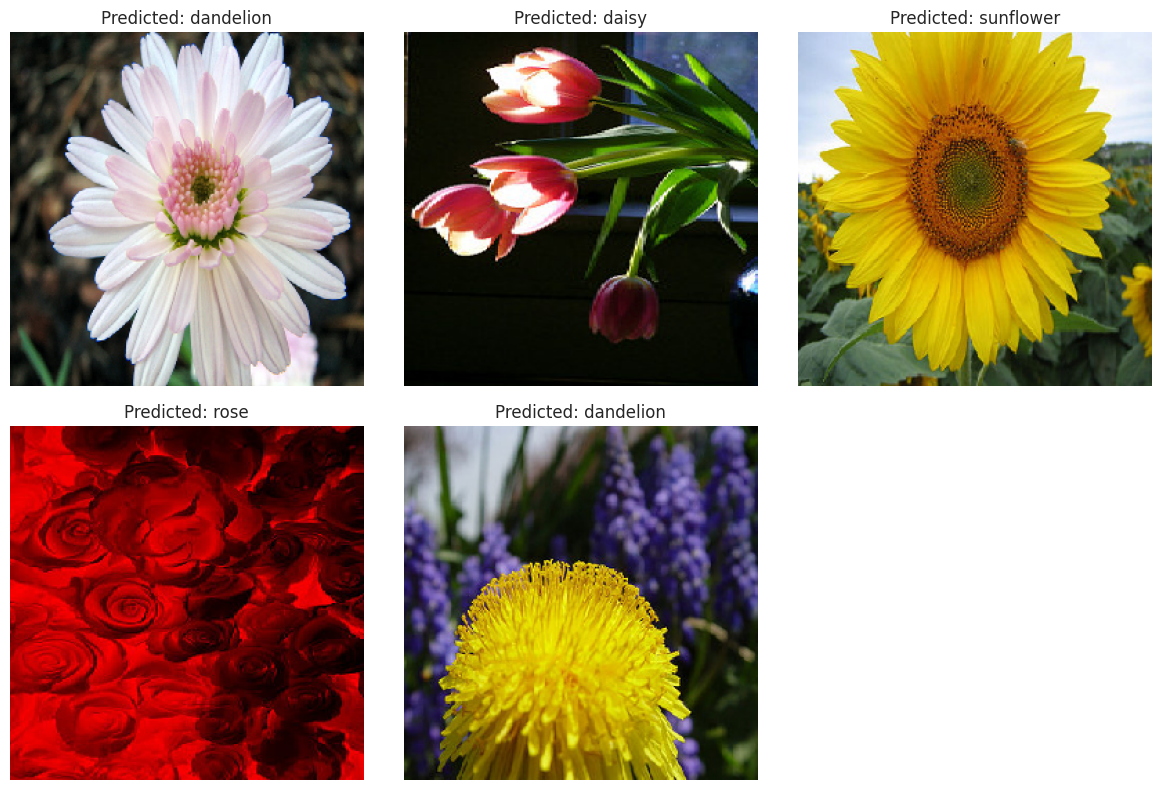

In [ ]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_images(image_dir, image_size=(256, 256)):
    images = []
    image_paths = []

    for fname in os.listdir(image_dir):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(image_dir, fname)
            img = image.load_img(img_path, target_size=image_size)
            img_array = image.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
            images.append(img_array)
            image_paths.append(img_path)

    return images, image_paths

# Predict and plot
def predict_and_plot_images(model, images, image_paths, class_names):
    plt.figure(figsize=(12, 12))
    for i, (img_array, img_path) in enumerate(zip(images, image_paths)):
        prediction = model.predict(img_array)
        predicted_label = class_names[np.argmax(prediction)]

        plt.subplot(3, 3, i + 1)
        img = tf.squeeze(img_array).numpy().astype("uint8")
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Load images
images, image_paths = load_and_preprocess_images(test_dir)

# Predict and plot
predict_and_plot_images(base_model, images, image_paths, class_names)




In [ ]:
base_model.save('base_model.h5')

## Building Regularized CNN Model

In [ ]:
def generate_model(image_height, image_width, nchannels, num_classes):
  """
  This function will generate a model with set of hyperparameters defined above.
  Input Args:
  image_height[int] = Height of an image.
  image_width[int] = Width of an image.
  nchannels[int] = Number of channels in image.
  num_classes[int] = Number of classes in dataset.
  Output Args:
  model-> A CNN model.
  """
  regularized_model = tf.keras.Sequential([
      # Rescaling and input layer, [For keras the input shape must be(image height, image width, channels)]
      layers.Rescaling(1./255, input_shape=(image_height,image_width, nchannels)),
      # First Block of Convolution and Pooling Operations.
      layers.Conv2D(32, (3,3), padding="same", activation="relu"),
      layers.BatchNormalization(),
      layers.MaxPooling2D(2,2),
      # Second Block of Convolution and Pooling Operations.
      layers.Conv2D(64, (3,3), padding="same", activation="relu"),
      layers.BatchNormalization(),
      layers.MaxPooling2D(2,2),
      # Third Block of Convolution and Pooling Operations.
      layers.Conv2D(128, (3,3), padding="same", activation="relu"),
      layers.BatchNormalization(),
      layers.MaxPooling2D(2,2),

      # Fourth Block of Convolution and Pooling Operations.
      layers.Conv2D(256, (3,3), padding="same", activation="relu"),
      layers.BatchNormalization(),
      layers.MaxPooling2D(2,2),

      # Fully connected classifier.
      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(128, activation="relu"),
      layers.Dropout(0.5),
      layers.Dense(64, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
  ])
  return regularized_model

In [ ]:
num_classes = len(class_names)
regularized_model = generate_model(img_height, img_width, 3, num_classes)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
regularized_model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])


In [ ]:
regularized_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,209,285 (65.65 MB)

 Trainable params: 17,208,325 (65.64 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
epochs = 50
history = regularized_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callbacks]
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - accuracy: 0.3015 - loss: 9.2304 - val_accuracy: 0.2948 - val_loss: 3.0134
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 183ms/step - accuracy: 0.2916 - loss: 3.4635 - val_accuracy: 0.2883 - val_loss: 1.6516
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step - accuracy: 0.3035 - loss: 1.8142 - val_accuracy: 0.2948 - val_loss: 1.5036
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - accuracy: 0.2979 - loss: 1.5860 - val_accuracy: 0.2688 - val_loss: 1.4806
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - accuracy: 0.3421 - loss: 1.5298 - val_accuracy: 0.3273 - val_loss: 1.4530
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.3565 - loss: 1.5243 - val_accuracy: 0.4117 - val_loss: 1.3278
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - accuracy: 0.3707 - loss: 1.4788 - val_accuracy: 0.4896 - val_loss: 1.2822
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 0.3737 - loss: 1.4531 - val_accu

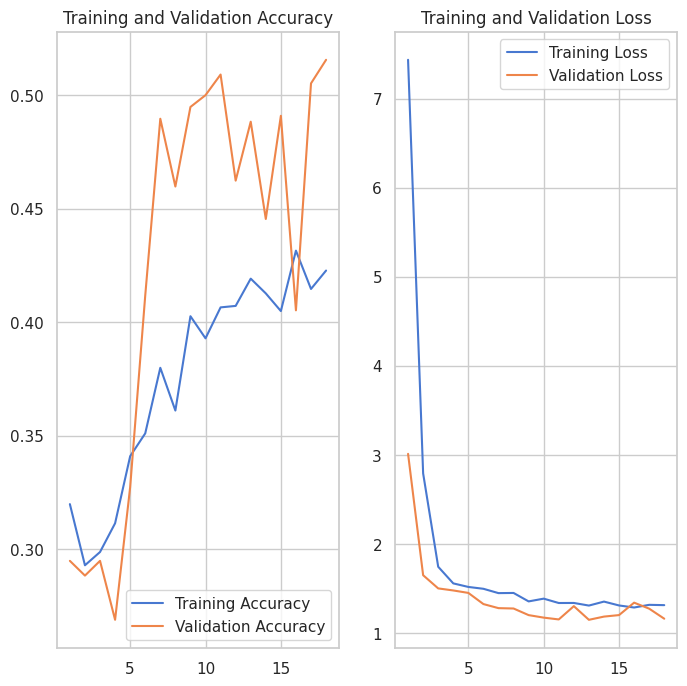

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Adjust the lengths of the arrays to match the actual number of epochs executed
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_accuracy = regularized_model.evaluate(val_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.5195 - loss: 1.1730
Test Loss: 1.1635416746139526
Test Accuracy: 0.515584409236908


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


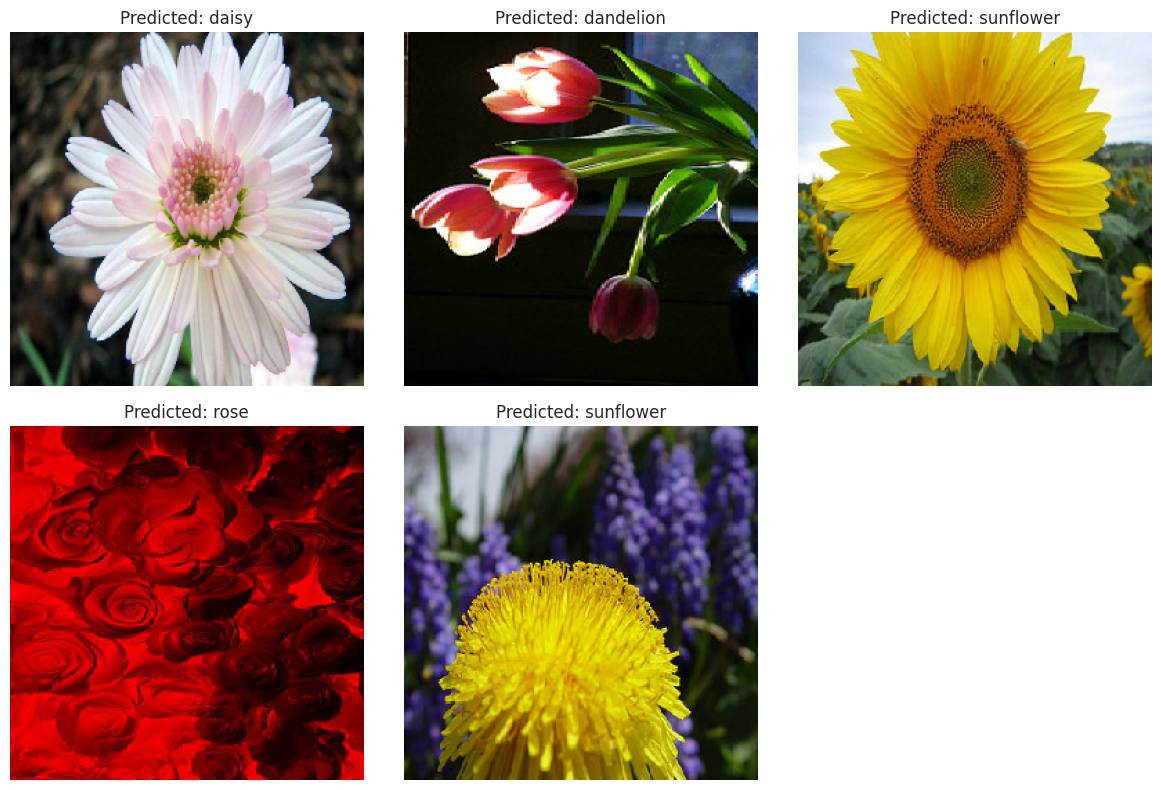

In [ ]:
def load_and_preprocess_images(image_dir, image_size=(256, 256)):
    images = []
    image_paths = []

    for fname in os.listdir(image_dir):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(image_dir, fname)
            img = image.load_img(img_path, target_size=image_size)
            img_array = image.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
            images.append(img_array)
            image_paths.append(img_path)

    return images, image_paths

# Predict and plot
def predict_and_plot_images(model, images, image_paths, class_names):
    plt.figure(figsize=(12, 12))
    for i, (img_array, img_path) in enumerate(zip(images, image_paths)):
        prediction = model.predict(img_array)
        predicted_label = class_names[np.argmax(prediction)]

        plt.subplot(3, 3, i + 1)
        img = tf.squeeze(img_array).numpy().astype("uint8")
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Load images
images, image_paths = load_and_preprocess_images(test_dir)

# Predict and plot
predict_and_plot_images(regularized_model, images, image_paths, class_names)


In [ ]:
regularized_model.save('regularized_model.h5')

## Transfer Learning with VGG16 model

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
import os

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
ds_path,
batch_size=32,
image_size=(224, 224),
shuffle=True,
seed=123,
validation_split=0.2,
subset="training",
)


val_ds = tf.keras.utils.image_dataset_from_directory(
ds_path,
batch_size=32,
image_size=(224, 224),
shuffle=True,
seed=123,
validation_split=0.2,
subset="validation",
)

Found 3850 files belonging to 5 classes.
Using 3080 files for training.
Found 3850 files belonging to 5 classes.
Using 770 files for validation.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

# Step 6: Add Custom Layers
vgg_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 5 classes
])

In [ ]:
vgg_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
vgg_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,821 (105.14 MB)

 Trainable params: 12,848,133 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
epochs=20
history = vgg_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 48s 326ms/step - accuracy: 0.6197 - loss: 20.7020 - val_accuracy: 0.8039 - val_loss: 1.0303
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 56s 219ms/step - accuracy: 0.8636 - loss: 0.7576 - val_accuracy: 0.7909 - val_loss: 0.7898
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.8881 - loss: 0.4999 - val_accuracy: 0.7896 - val_loss: 1.0374
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 223ms/step - accuracy: 0.9023 - loss: 0.5096 - val_accuracy: 0.7961 - val_loss: 1.0573
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - accuracy: 0.9031 - loss: 0.4771 - val_accuracy: 0.8169 - val_loss: 0.8916
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - accuracy: 0.9150 - loss: 0.3490 - val_accuracy: 0.8104 - val_loss: 0.8666
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - accuracy: 0.9204 - loss: 0.3924 - val_accuracy: 0.8130 - val_loss: 0.8555
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.9251 - loss: 0.2945 - val_acc

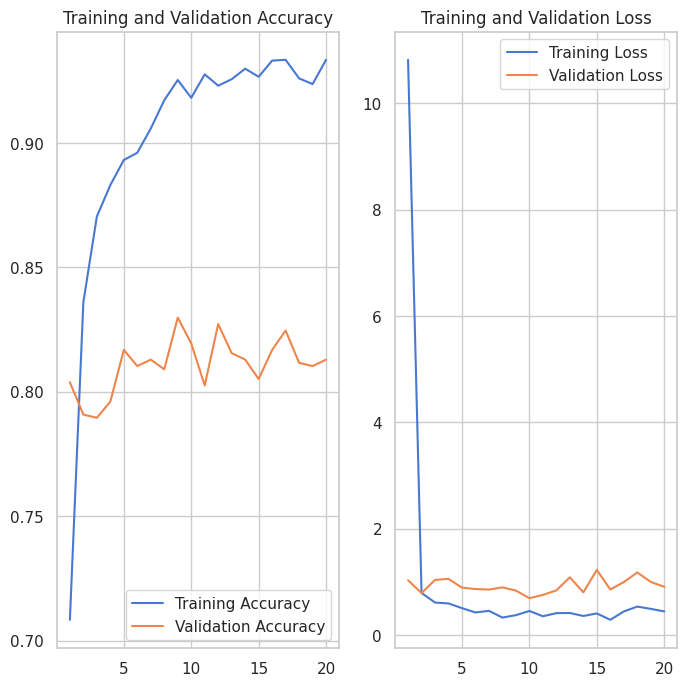

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Adjust the lengths of the arrays to match the actual number of epochs executed
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(val_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.8067 - loss: 0.9943
Test Loss: 0.9073370099067688
Test Accuracy: 0.8129870295524597


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


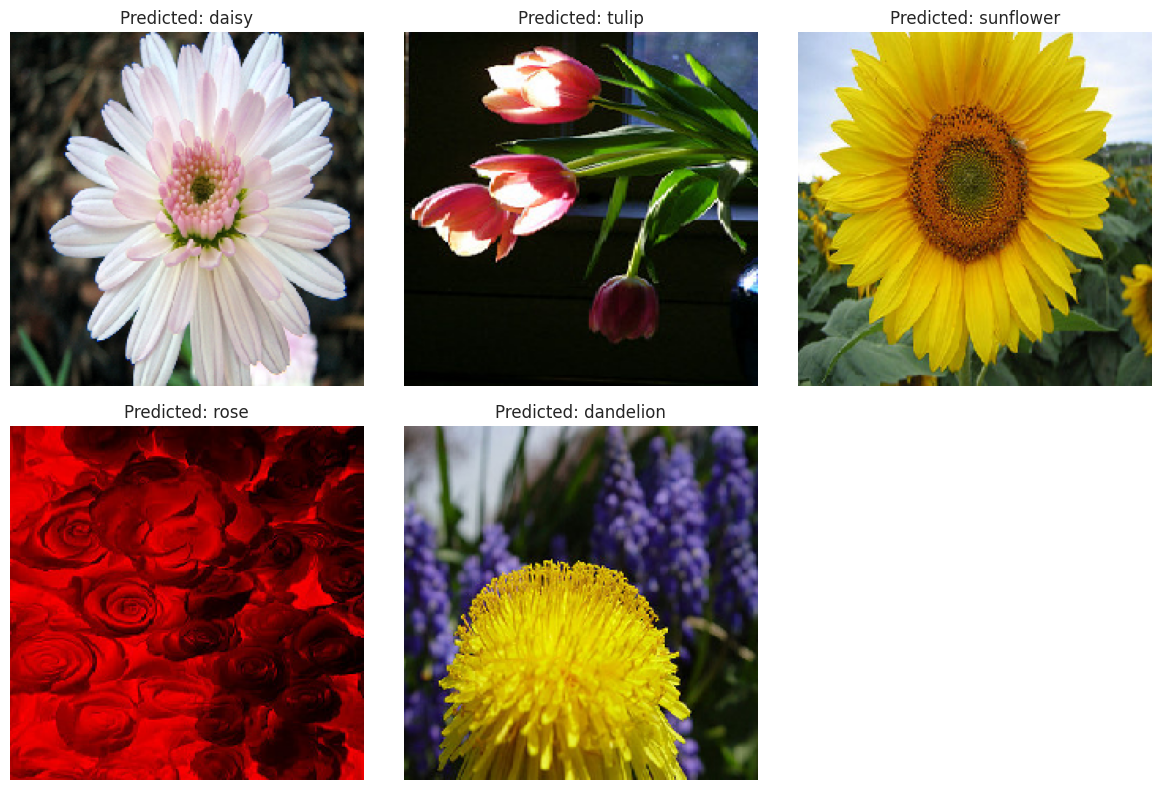

In [ ]:
def load_and_preprocess_images(image_dir, image_size=(224, 224)):
    images = []
    image_paths = []

    for fname in os.listdir(image_dir):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(image_dir, fname)
            img = image.load_img(img_path, target_size=image_size)
            img_array = image.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
            images.append(img_array)
            image_paths.append(img_path)

    return images, image_paths

# Predict and plot
def predict_and_plot_images(model, images, image_paths, class_names):
    plt.figure(figsize=(12, 12))
    for i, (img_array, img_path) in enumerate(zip(images, image_paths)):
        prediction = model.predict(img_array)
        predicted_label = class_names[np.argmax(prediction)]

        plt.subplot(3, 3, i + 1)
        img = tf.squeeze(img_array).numpy().astype("uint8")
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Load images
images, image_paths = load_and_preprocess_images(test_dir)

# Predict and plot
predict_and_plot_images(vgg_model, images, image_paths, class_names)


In [ ]:
vgg_model.save('vgg_model.h5')